<a href="https://colab.research.google.com/github/CGrannan/building-boardgame-recommendation-systems/blob/master/NLP_content_based_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

For this project we are looking to improve the shopping experience when buying boardgames online. There is an extremely large number of boardgames that have been produced in the last 20 years, and it is difficult to find games that you might like among all of the noise. Furthermore, many of these games are relatively expensive and buying a boardgame that you don't like is a really unpleasant experience. Because of these issues, it is often safer from a customer standpoint to only buy a few games that you have played before. To increase sales, online retailers of boardgames can make use of recommendation systems to suggest games to customers similar to games they have played before, or rated similarly by other customers. We intend to build several types of recommendation systems and evaluate how effective they will be for future sales.

Our dataset for this project consists of statistics for 119,978 boardgames obtained from the [boardgamegeek](https://boardgamegeek.com/) website. The columns for our dataset are described below. We also have another set of data consisting of 3.7 million reviews (~2000 reviews each for the 2000 games with the highest number of reviews). These were also obtained through the boardgamegeek website. Over the course of this project we go over several types of recommendation systems and ultimately develop a NLP content-based recommendation system, a KNN collaboratively-filtered recommendation system, and a pyspark ALS recommendation system. It is highly recommended that an online retailer for boardgames makes use of at least one of these systems to connect customers with targeted games for sale.

Column Descriptions:

name - Name of boardgame

type - Whether the item is a boardgame or expansion

year - Year the game was published

designer - Boardgame designer's name

artist - Boardgame artist's name

publisher - Boardgame publisher

min_players - Minimum number of players required to play.

max_players - Maximum number of players allowed.

play_time - Typical length of one game.

min_age - Recommended minimum age.

num_ratings - How many users have rated this game.

avg_rating - Mean of ratings for this game.

bayes_avg - Weighted mean rating for this game.

weight - Strategic complexity of game on a 1-5 point scale.

categories - Tags to identify type of game (ie. economic, card game, abstract strategy).

mechanics - Mechanics used in game (ie. set collection, trick taking, hand management).

families - Tags to identify theme of game (ie. countries or types of animals).

description - Short verbal description of the game. Can contain many of the other columns by default.

min_playtime - Shortest length of time for one game.

max_playtime - Longest length of time for one game.

bgg_rank - Overall rank on boardgamegeek website.

boardgame_rank - Overall ranking amongst all boardgames.

# Introduction
In this notebook we will take our statistics dataframe and create a content-based recommendation system using natural language processing. To start we will load in some relevant libraries and our data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

!pip install nltk
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/CapstoneProject/games_with_descriptions')
df.head()

,name,type,year,designer,artist,publisher,min_players,max_players,play_time,min_age,num_ratings,avg_rating,bayes_avg,weight,categories,mechanics,families,description,min_playtime,max_playtime,bgg_rank,boardgame_rank
1,Die Macher,boardgame,1986.0,Karl-Heinz Schmiel,Marcus Gschwendtner,Hans im Glück,3.0,5.0,240.0,14.0,5172,7.63044,7.14476,4.3245,"['Economic', 'Negotiation', 'Political']","['Alliances', 'Area Majority / Influence', 'Au...","['Country: Germany', 'Political: Elections', '...",Die Macher is a game about seven sequential po...,240,240,275.0,275.0
2,Dragonmaster,boardgame,1981.0,"G. W. ""Jerry"" D'Arcey",Bob Pepper,E.S. Lowe,3.0,4.0,30.0,12.0,547,6.61736,5.79938,1.9630,"['Card Game', 'Fantasy']",['Trick-taking'],['Creatures: Dragons'],Dragonmaster is a trick-taking card game based...,30,30,3613.0,3613.0
3,Samurai,boardgame,1998.0,Reiner Knizia,Franz Vohwinkel,Fantasy Flight Games,2.0,4.0,60.0,10.0,14580,7.44945,7.24741,2.4899,"['Abstract Strategy', 'Medieval']","['Area Majority / Influence', 'Hand Management...","['Country: Japan', 'Series: Euro Classics (Rei...",Samurai is set in medieval Japan. Players comp...,30,60,206.0,206.0
4,Tal der Könige,boardgame,1992.0,Christian Beierer,Thomas di Paolo,KOSMOS,2.0,4.0,60.0,12.0,339,6.60773,5.69730,2.6667,['Ancient'],"['Action Points', 'Area Majority / Influence',...","['Containers: Triangular Boxes', 'Country: Egy...",When you see the triangular box and the luxuri...,60,60,4780.0,4780.0
5,Acquire,boardgame,1964.0,Sid Sackson,Scott Okumura,3M,2.0,6.0,90.0,12.0,18021,7.34130,7.15733,2.5050,['Economic'],"['Hand Management', 'Income', 'Investment', 'M...",['Series: 3M Bookshelf Series'],"In Acquire, each player strategically invests ...",90,90,264.0,264.0


In [ ]:
len(df)

119978

We will also load in some prewritten functions.

In [ ]:
% run /content/drive/MyDrive/CapstoneProject/nlp_cont_based.py

# Data Cleaning

We cannot use the whole dataset for this recommendation system since we don't have the working memory. We will only use the 2000 most popular (most ratings) games, just like we will for our collaborative-filtering recommendation systems.

In [ ]:
df = df.sort_values(by='num_ratings', ascending=False)[:2000]
len(df)

2000

In [ ]:
df.head()

,name,type,year,designer,artist,publisher,min_players,max_players,play_time,min_age,num_ratings,avg_rating,bayes_avg,weight,categories,mechanics,families,description,min_playtime,max_playtime,bgg_rank,boardgame_rank
30549,Pandemic,boardgame,2008.0,Matt Leacock,Josh Cappel,"Z-Man Games, Inc.",2.0,4.0,45.0,8.0,98874,7.61069,7.51287,2.4131,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...","In Pandemic, several virulent diseases have br...",45,45,97.0,97.0
822,Carcassonne,boardgame,2000.0,Klaus-Jürgen Wrede,Doris Matthäus,Hans im Glück,2.0,5.0,45.0,7.0,98777,7.41838,7.30920,1.9142,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...","['Components: Meeples (Black)', 'Components: M...",Carcassonne is a tile-placement game in which ...,30,45,178.0,178.0
13,Catan,boardgame,1995.0,Klaus Teuber,Volkan Baga,KOSMOS,3.0,4.0,120.0,10.0,98557,7.15916,6.99499,2.3236,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...","['Game: Catan', 'Promotional: Promo Board Games']","In CATAN (formerly The Settlers of Catan), pla...",60,120,384.0,384.0
68448,7 Wonders,boardgame,2010.0,Antoine Bauza,Miguel Coimbra,Repos Production,2.0,7.0,30.0,10.0,82043,7.75586,7.65665,2.3308,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Card Drafting', 'Drafting', 'Hand Management...","['Game: 7 Wonders', 'Mechanism: Tableau Buildi...",You are the leader of one of the 7 great citie...,30,30,58.0,58.0
36218,Dominion,boardgame,2008.0,Donald X. Vaccarino,Matthias Catrein,Rio Grande Games,2.0,4.0,30.0,13.0,76396,7.62267,7.51565,2.3588,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...","['Crowdfunding: Wspieram', 'Game: Dominion', '...","""You are a monarch, like your parents before y...",30,30,96.0,96.0


Now we will inspect some columns to check our data. First up is the designer column.

In [ ]:
df.designer.value_counts()

Reiner Knizia       55
(Uncredited)        28
Bruno Cathala       27
Martin Wallace      27
Alan R. Moon        26
                    ..
William Jacobson     1
Benoit Vogt          1
Jack Degnan          1
Mikkel Bertelsen     1
Rita Modl            1
Name: designer, Length: 794, dtype: int64

In [ ]:
df.designer = df.designer.replace(['(Uncredited)', 'uncredited'], 'uncredited designer')
df.designer.value_counts()

Reiner Knizia          55
uncredited designer    31
Bruno Cathala          27
Martin Wallace         27
Alan R. Moon           26
                       ..
Scott Abbot             1
Benoit Vogt             1
Jack Degnan             1
Mikkel Bertelsen        1
Rita Modl               1
Name: designer, Length: 793, dtype: int64

We had two different entries for uncredited, and I wanted to add designer so when we move on to our nlp work, the bigrams will distinguish between uncredited designers and artists. Now we will do the same with the artist column.

In [ ]:
df.artist.value_counts()

uncredited               114
Franz Vohwinkel           47
(Uncredited)              41
Klemens Franz             40
Michael Menzel            37
                        ... 
Mélanie Grandgirard        1
Andre Garcia               1
Francisco Rico Torres      1
Legruth                    1
Chechu Nieto               1
Name: artist, Length: 828, dtype: int64

In [ ]:
df.artist = df.artist.replace(['(Uncredited)', 'uncredited'], 'uncredited artist')
df.artist.value_counts()

uncredited artist      155
Franz Vohwinkel         47
Klemens Franz           40
Cyrille Daujean         37
Michael Menzel          37
                      ... 
Joshua Panelo            1
Riccardo Pieruccini      1
Anthony Wolff            1
Thomas Denmark           1
Carine Hinder            1
Name: artist, Length: 827, dtype: int64

Next up we will look at the publisher column.

In [ ]:
df.publisher.value_counts()

Fantasy Flight Games    87
999 Games               59
Asmodee                 55
Hans im Glück           53
Days of Wonder          42
                        ..
LEGO                     1
Educational Insights     1
Pretzel Games            1
Rawstone                 1
Devil Pig Games          1
Name: publisher, Length: 452, dtype: int64

In [ ]:
df.publisher = df.publisher.replace(['(Self-Published)', '(Web published)', '(Unknown)'], ['self published', 'web published', 'unknown'])
df.publisher.value_counts()

Fantasy Flight Games    87
999 Games               59
Asmodee                 55
Hans im Glück           53
Days of Wonder          42
                        ..
Educa Korea              1
Diseños Orbitales        1
MindWare                 1
Pressman Toy Corp.       1
Devil Pig Games          1
Name: publisher, Length: 452, dtype: int64

We changed some values to get rid of some punctuation, but otherwise this column looks good. Let's look for null values.

In [ ]:
df.isna().sum()

name                0
type                0
year                0
designer            0
artist              0
publisher           0
min_players         0
max_players         0
play_time           0
min_age             0
num_ratings         0
avg_rating          0
bayes_avg           0
weight              0
categories          7
mechanics          13
families           84
description         0
min_playtime        0
max_playtime        0
bgg_rank          250
boardgame_rank    250
dtype: int64

We had cleaned most of this dataframe before, so it is not surprising that we don't have many null values. We will need to address the ones we do have before moving on. First, we can fill our categories and mechanic null values with 'unknown' to represent the missing values. We will fill null values in the families column with 'none' to also show the missing information.

In [ ]:
df = df.fillna({'categories': 'unknown', 'mechanics': 'unknown', 'families': 'none'})
df.isna().sum()

name                0
type                0
year                0
designer            0
artist              0
publisher           0
min_players         0
max_players         0
play_time           0
min_age             0
num_ratings         0
avg_rating          0
bayes_avg           0
weight              0
categories          0
mechanics           0
families            0
description         0
min_playtime        0
max_playtime        0
bgg_rank          250
boardgame_rank    250
dtype: int64

Before addressing the null values, I want to see how similar the bgg_rank and boardgame_rank columns are.

In [ ]:
sum(df.bgg_rank == df.boardgame_rank)

1750

It appears they are the same column. We will drop the bgg_rank column out.

In [ ]:
df.drop(['bgg_rank'], axis=1, inplace=True)
df.head()

,name,type,year,designer,artist,publisher,min_players,max_players,play_time,min_age,num_ratings,avg_rating,bayes_avg,weight,categories,mechanics,families,description,min_playtime,max_playtime,boardgame_rank
30549,Pandemic,boardgame,2008.0,Matt Leacock,Josh Cappel,"Z-Man Games, Inc.",2.0,4.0,45.0,8.0,98874,7.61069,7.51287,2.4131,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...","In Pandemic, several virulent diseases have br...",45,45,97.0
822,Carcassonne,boardgame,2000.0,Klaus-Jürgen Wrede,Doris Matthäus,Hans im Glück,2.0,5.0,45.0,7.0,98777,7.41838,7.30920,1.9142,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...","['Components: Meeples (Black)', 'Components: M...",Carcassonne is a tile-placement game in which ...,30,45,178.0
13,Catan,boardgame,1995.0,Klaus Teuber,Volkan Baga,KOSMOS,3.0,4.0,120.0,10.0,98557,7.15916,6.99499,2.3236,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...","['Game: Catan', 'Promotional: Promo Board Games']","In CATAN (formerly The Settlers of Catan), pla...",60,120,384.0
68448,7 Wonders,boardgame,2010.0,Antoine Bauza,Miguel Coimbra,Repos Production,2.0,7.0,30.0,10.0,82043,7.75586,7.65665,2.3308,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Card Drafting', 'Drafting', 'Hand Management...","['Game: 7 Wonders', 'Mechanism: Tableau Buildi...",You are the leader of one of the 7 great citie...,30,30,58.0
36218,Dominion,boardgame,2008.0,Donald X. Vaccarino,Matthias Catrein,Rio Grande Games,2.0,4.0,30.0,13.0,76396,7.62267,7.51565,2.3588,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...","['Crowdfunding: Wspieram', 'Game: Dominion', '...","""You are a monarch, like your parents before y...",30,30,96.0


To fill the null values in the boardgame_rank column, we will use 'N/A' to show that the games are unranked.

In [ ]:
df.boardgame_rank = df.boardgame_rank.fillna('N/A')
df.isna().sum()

name              0
type              0
year              0
designer          0
artist            0
publisher         0
min_players       0
max_players       0
play_time         0
min_age           0
num_ratings       0
avg_rating        0
bayes_avg         0
weight            0
categories        0
mechanics         0
families          0
description       0
min_playtime      0
max_playtime      0
boardgame_rank    0
dtype: int64

Before we move on, I want to create a list of board game names to help with our recommendations later.

Great! Our data is all cleaned up and ready for exploration.

# EDA

Before we move on to modeling, let's look at the distributions of our data. First off, I want to look at how many games were published each year.

([<matplotlib.axis.XTick at 0x7ff1520722e8>,
 [Text(0, 0, '-3000.0'),
  Text(0, 0, '1530.0'),
  Text(0, 0, '1906.0'),
  Text(0, 0, '1955.0'),
  Text(0, 0, '1970.0'),
  Text(0, 0, '1981.0'),
  Text(0, 0, '1991.0'),
  Text(0, 0, '2001.0'),
  Text(0, 0, '2011.0')])

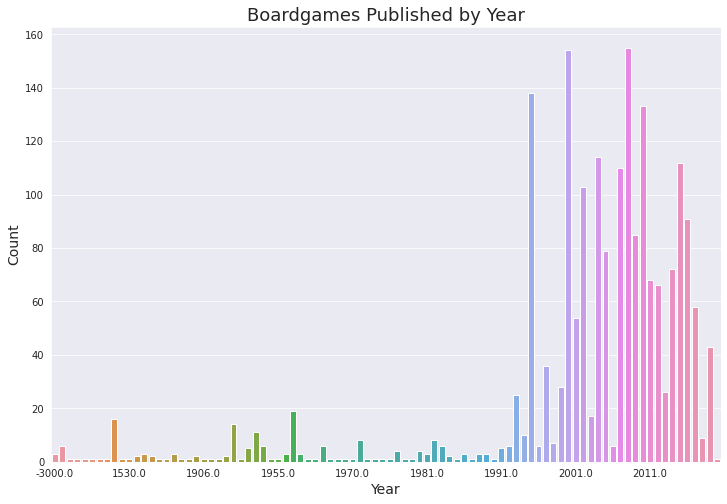

In [ ]:
fig = plt.figure(figsize=(12,8))
g = sns.barplot(x= df.year.unique(), y= df.year.value_counts())
plt.title('Boardgames Published by Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)

new_ticks = [i.get_text() for i in g.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 10), new_ticks[::10])

The earliest games are from ~3000 BC, which are games like Go and the Royal Game of Ur. Most years have fewer than 20 games published until we hit the mid-1990's. Then boardgames seem to become more popular and we have many more games published each year. Now let's take a look at the playing times for our games.

([<matplotlib.axis.XTick at 0x7ff151d9db00>,
 [Text(0, 0, '0.0'),
  Text(0, 0, '5.0'),
  Text(0, 0, '20.0'),
  Text(0, 0, '32.0'),
  Text(0, 0, '42.0'),
  Text(0, 0, '60.0'),
  Text(0, 0, '80.0'),
  Text(0, 0, '100.0'),
  Text(0, 0, '115.0'),
  Text(0, 0, '135.0'),
  Text(0, 0, '180.0'),
  Text(0, 0, '240.0'),
  Text(0, 0, '360.0'),
  Text(0, 0, '1000.0')])

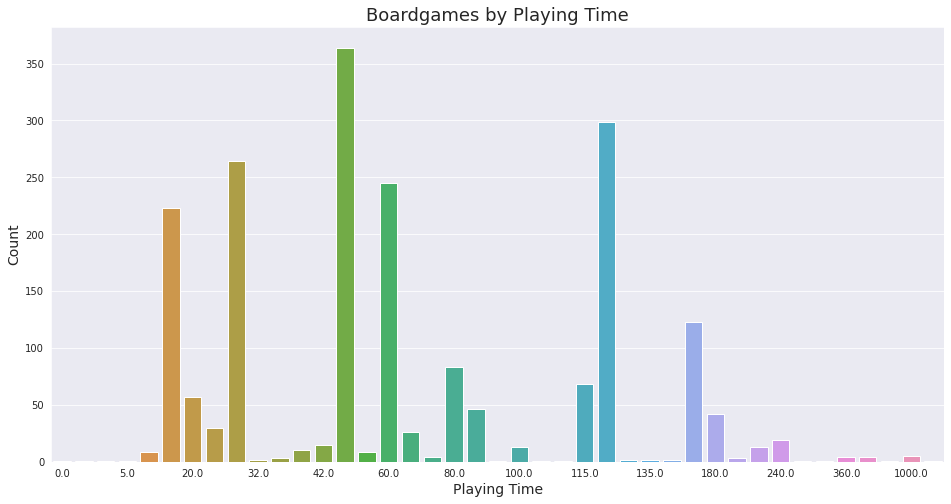

In [ ]:
fig = plt.figure(figsize=(16,8))
g = sns.barplot(x= df.play_time.unique(), y= df.play_time.value_counts())
plt.title('Boardgames by Playing Time', fontsize=18)
plt.xlabel('Playing Time', fontsize=14)
plt.ylabel('Count', fontsize=14)

new_ticks = [i.get_text() for i in g.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 3), new_ticks[::3])

Most of our games have playing times in intervals of 15 minutes. We see large spikes at 15 mins, 30 mins, 45 mins, 1 hour and 2 hours. There are some games that have over 1000 mins (16 hours) of playtime! These seem to be mostly large-scale minature based war games.  Next up we will look at the minimum and maximum numbers of players for each game.

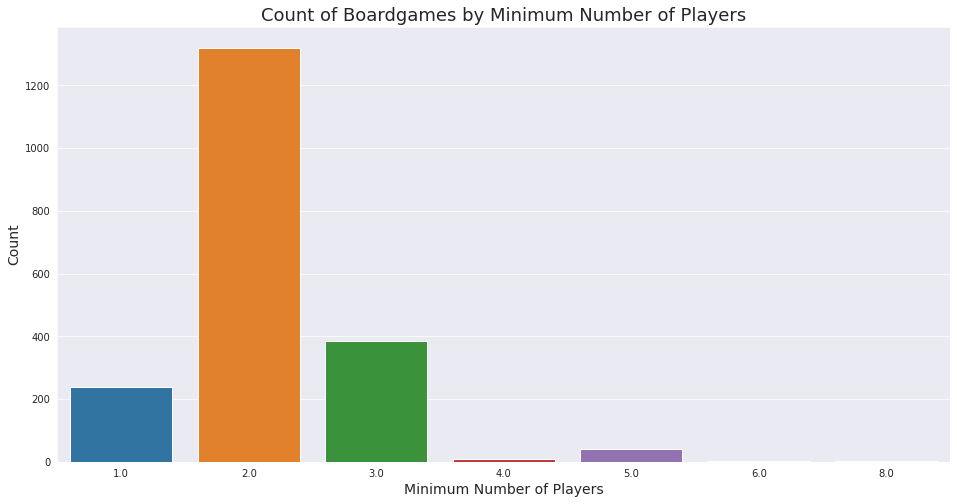

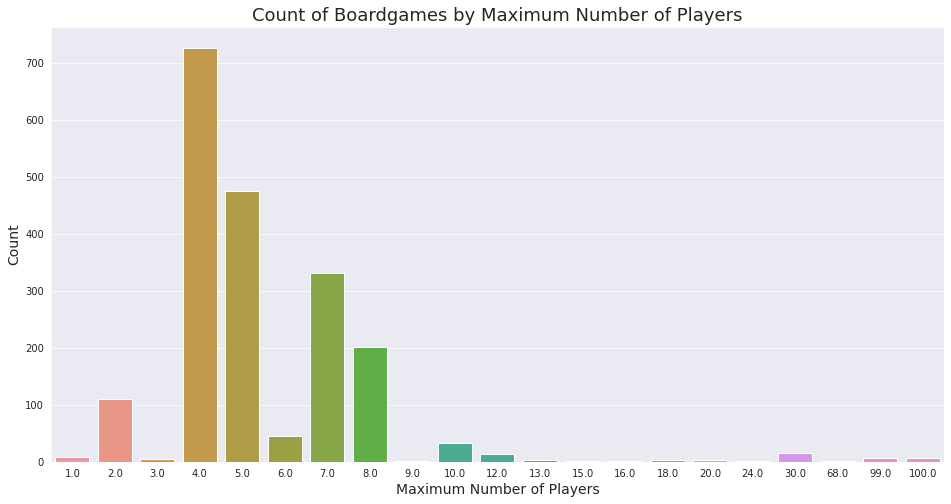

In [ ]:
fig = plt.figure(figsize=(16,8))
g = sns.barplot(x= df.min_players.unique(), y= df.min_players.value_counts())
plt.title('Count of Boardgames by Minimum Number of Players', fontsize=18)
plt.xlabel('Minimum Number of Players', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

fig = plt.figure(figsize=(16,8))
g = sns.barplot(x= df.max_players.unique(), y= df.max_players.value_counts())
plt.title('Count of Boardgames by Maximum Number of Players', fontsize=18)
plt.xlabel('Maximum Number of Players', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

The minimum players graph is very straight forward and expected. Most games require at lest 2 or 3 players. There are a fair number of games that you can play by yourself, and some that require larger groups. The maximum player graph is a little more spread out. Most games top out at 4 or 5 players, but there are some party games that enable significantly larger numbers of players. There are some games that you can only play by yourself or with a partner, but they are relatively few. Next up we will bin the games by numbers of ratings and see our distribution for how many ratings each game has.

In [ ]:
stops_for_review_counts = [1, 5000, 10000, 50000, 100000]
review_count_bins = {}


for index in range(1, len(stops_for_review_counts)):
    review_count_bins[str(stops_for_review_counts[index - 1]) + ' - ' + str(stops_for_review_counts[index])] = \
        len(df.num_ratings[(df.num_ratings > stops_for_review_counts[index - 1]) & \
            (df.num_ratings <= stops_for_review_counts[index])])


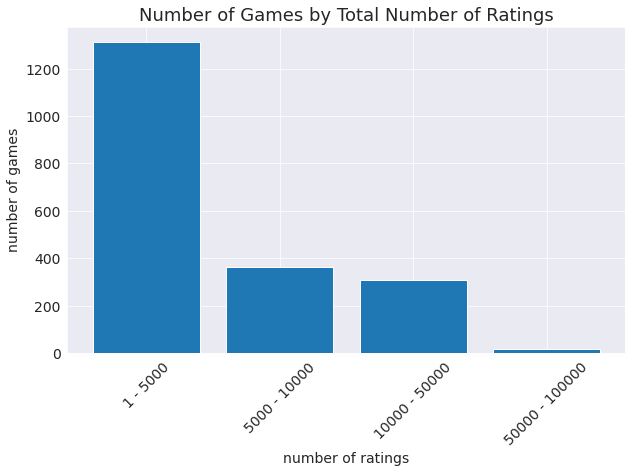

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(review_count_bins.keys(), review_count_bins.values())
plt.tick_params(axis = 'x', labelsize = 14, rotation = 45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.xlabel('number of ratings', fontsize = 14)
plt.ylabel('number of games', fontsize = 14)
plt.title('Number of Games by Total Number of Ratings', fontsize = 18)
plt.show()

Most games have fewer than 5000 reviews, but some games have as many of 98,000. There are definitely games that are significantly more popular than others. To look for significant effects, we will mostly be focusing on the games toward the top end of this chart. We will be looking at games with lots of reviews to try and get as much crossover between users as possible. 

Now let's move on to modeling.

# Modeling

To prepare for modeling we will reset our index to regain a game_id column. This will close up the gaps left by our dropped columns. I will also pull an array of our name column to use in our recommendation function.

In [ ]:
df = df.reset_index().rename(columns={"index": 'game_id'})
df.head()
names = pd.Series(df.name)

Now we will combine all columns containing text into one bag of words for each game. Then we will tokenize the strings, remove stopwords and punctuation, and lemmatize the words. Finally, we will pull open the first bag of words to look at the results.

In [ ]:
df['bag_of_words'] = df['name'] + ' ' + df['designer'] + ' ' + df['artist'] + ' ' + df['publisher'] + ' ' + df['categories'] + ' ' + df['mechanics'] + ' ' + df['families'] + ' ' + df['description']

df['bag_of_words'] = df['bag_of_words'].map(word_tokenize).values


In [ ]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
lemmatizer = WordNetLemmatizer()

for i, bow in enumerate(df.bag_of_words):
  df.bag_of_words[i] = [lemmatizer.lemmatize(word.lower()) for word in bow if word not in stopwords_list]
  
df.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,game_id,name,type,year,designer,artist,publisher,min_players,max_players,play_time,min_age,num_ratings,avg_rating,bayes_avg,weight,categories,mechanics,families,description,min_playtime,max_playtime,boardgame_rank,bag_of_words
0,30549,Pandemic,boardgame,2008.0,Matt Leacock,Josh Cappel,"Z-Man Games, Inc.",2.0,4.0,45.0,8.0,98874,7.61069,7.51287,2.4131,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...","In Pandemic, several virulent diseases have br...",45,45,97,"[pandemic, matt, leacock, josh, cappel, z-man,..."
1,822,Carcassonne,boardgame,2000.0,Klaus-Jürgen Wrede,Doris Matthäus,Hans im Glück,2.0,5.0,45.0,7.0,98777,7.41838,7.30920,1.9142,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...","['Components: Meeples (Black)', 'Components: M...",Carcassonne is a tile-placement game in which ...,30,45,178,"[carcassonne, klaus-jürgen, wrede, doris, matt..."
2,13,Catan,boardgame,1995.0,Klaus Teuber,Volkan Baga,KOSMOS,3.0,4.0,120.0,10.0,98557,7.15916,6.99499,2.3236,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...","['Game: Catan', 'Promotional: Promo Board Games']","In CATAN (formerly The Settlers of Catan), pla...",60,120,384,"[catan, klaus, teuber, volkan, baga, kosmos, '..."
3,68448,7 Wonders,boardgame,2010.0,Antoine Bauza,Miguel Coimbra,Repos Production,2.0,7.0,30.0,10.0,82043,7.75586,7.65665,2.3308,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Card Drafting', 'Drafting', 'Hand Management...","['Game: 7 Wonders', 'Mechanism: Tableau Buildi...",You are the leader of one of the 7 great citie...,30,30,58,"[7, wonder, antoine, bauza, miguel, coimbra, r..."
4,36218,Dominion,boardgame,2008.0,Donald X. Vaccarino,Matthias Catrein,Rio Grande Games,2.0,4.0,30.0,13.0,76396,7.62267,7.51565,2.3588,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...","['Crowdfunding: Wspieram', 'Game: Dominion', '...","""You are a monarch, like your parents before y...",30,30,96,"[dominion, donald, x., vaccarino, matthias, ca..."


In [ ]:
df.bag_of_words[1]

['carcassonne',
 'klaus-jürgen',
 'wrede',
 'doris',
 'matthäus',
 'han',
 'im',
 'glück',
 "'city",
 'building',
 "'medieval",
 "'territory",
 'building',
 "'area",
 'majority',
 'influence',
 "'map",
 'addition',
 "'tile",
 'placement',
 "'components",
 'meeples',
 'black',
 "'components",
 'meeples',
 'blue',
 "'components",
 'meeples',
 'green',
 "'components",
 'meeples',
 'red',
 "'components",
 'meeples',
 'yellow',
 "'country",
 'france',
 "'game",
 'carcassonne',
 "'region",
 'languedoc',
 'france',
 'carcassonne',
 'tile-placement',
 'game',
 'player',
 'draw',
 'place',
 'tile',
 'piece',
 'southern',
 'french',
 'landscape',
 'the',
 'tile',
 'might',
 'feature',
 'city',
 'road',
 'cloister',
 'grassland',
 'combination',
 'thereof',
 'must',
 'placed',
 'adjacent',
 'tile',
 'already',
 'played',
 'way',
 'city',
 'connected',
 'city',
 'road',
 'road',
 'etcetera',
 'having',
 'placed',
 'tile',
 'player',
 'decide',
 'place',
 'one',
 'meeples',
 'one',
 'area',
 'city'

Our bag of words look well-processed. One last thing I want to do before we actually model is to look at the most popular words in our dataset. We will make one large bag of words and create a wordcloud to show which words are most common.

In [ ]:
big_bag_of_words = ''
for i, bow in enumerate(df.bag_of_words):
  for word in bow:
    big_bag_of_words += (word + ' ')

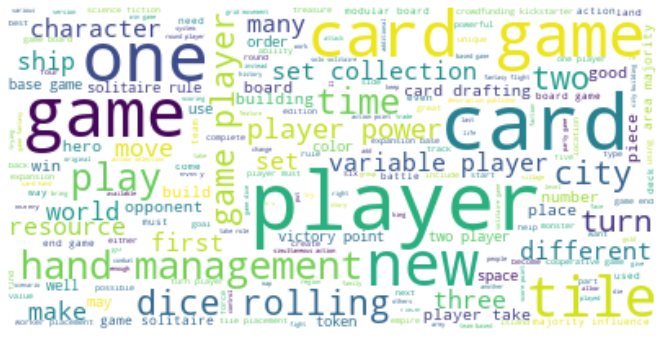

In [ ]:
create_wordcloud(big_bag_of_words)

Now we can see which words appear the most in our dataset. Several of these are unsurprising, such as player, card, game, and tile.  We also see some popular bigrams like card game and dice rolling. Through this word cloud we can see that several mechanics take prominent roles (hand management, dice rolling, card drafting). One interesting thing to me is to see the word 'ship' so prominently. This indicates a large number of games will be space or sea themed and may be confused for each other.

Now, on to proper modeling! We will build 2 models for nlp processing, a count vector model, and a tf-idf vector model. We will start with the count vector model. With this approach we will be counting the frequency of each word in each bag of words and convert these counts into vectors. Then we will calculate recommendations based on similarites between vectors.

In [ ]:
# Create a vectorizer
count = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=5, preprocessor=' '.join)
# Transform our bags of words into vectors
count_matrix = count.fit_transform(df['bag_of_words'])
# Compute similarities
cos_sim = linear_kernel(count_matrix, count_matrix)

Now let's look at some recommendations using a handy function we have written. We will look at the results for four games to make sure we are getting distinct results. we will also look at a wordcloud for each game to see what terms are most prevalent in each game.

In [ ]:
count_gloom = recommend('Gloomhaven', names, df, cos_sim, 5)
count_gloom

['HeroQuest',
 'Pokémon Trading Card Game',
 'Rivals for Catan',
 'Ticket to Ride: The Card Game',
 'Gloomhaven']

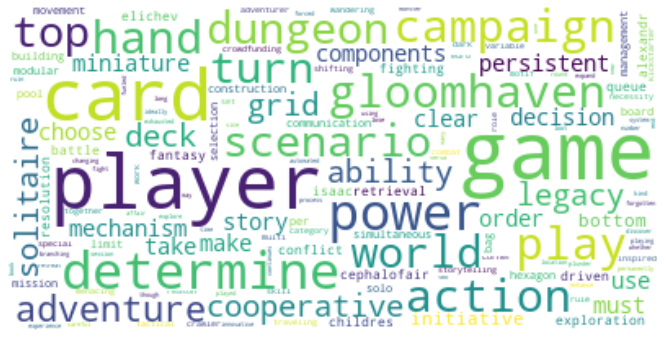

In [ ]:
bow = df[df.name == 'Gloomhaven']['bag_of_words'].item()
text = ''
for word in bow:
  text += (word + ' ')

create_wordcloud(text)

In [ ]:
count_pan = recommend('Pandemic', names, df, cos_sim, 5)
count_pan

['Pandemic',
 'Rivals for Catan',
 'Ticket to Ride: The Card Game',
 'HeroQuest',
 'Skull King']

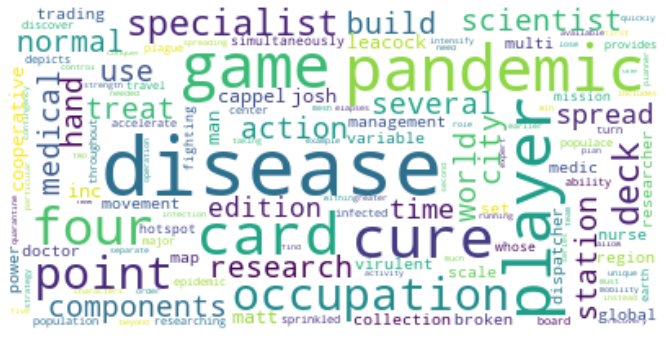

In [ ]:
bow = df[df.name == 'Pandemic']['bag_of_words'].item()
text = ''
for word in bow:
  text += (word + ' ')

create_wordcloud(text)

In [ ]:
count_carc = recommend('Carcassonne', names, df, cos_sim, 5)
count_carc

['Key Harvest',
 'Infinite City',
 'Carcassonne Big Box 5',
 'Elfenland',
 'The Castles of Burgundy']

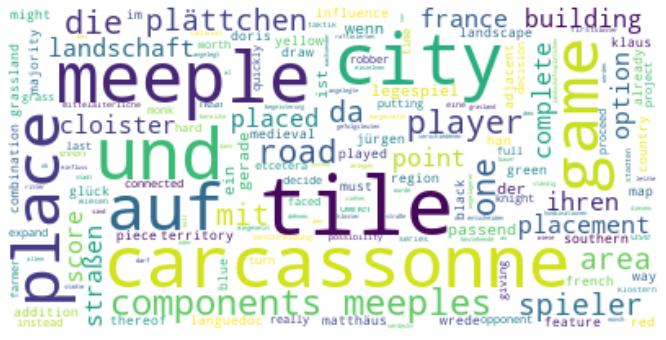

In [ ]:
bow = df[df.name == 'Carcassonne']['bag_of_words'].item()
text = ''
for word in bow:
  text += (word + ' ')

create_wordcloud(text)

In [ ]:
count_mon = recommend('Monopoly', names, df, cos_sim, 5)
count_mon

['Traders of Osaka',
 'History of the World',
 'Rivals for Catan',
 'Risk Legacy',
 'Ticket to Ride: The Card Game']

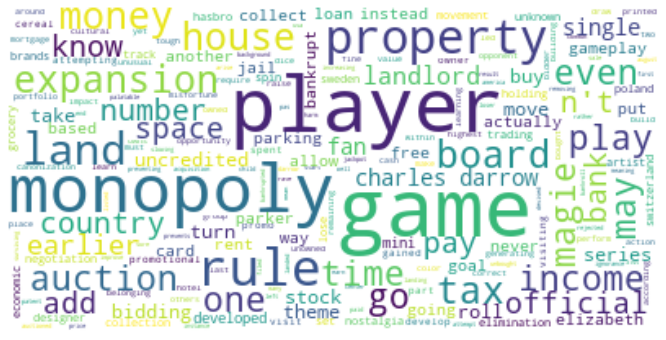

In [ ]:
bow = df[df.name == 'Monopoly']['bag_of_words'].item()
text = ''
for word in bow:
  text += (word + ' ')

create_wordcloud(text)

Overall we have pretty good recommendations here. There are games with similar themes and mechanics. I'm surprised at the overlap between the recommendations for Gloomhaven and Pandemic as they are very different games. There must be some overlapping words or phrases that are reflected in Rivals for Catan, Ticket to Ride: the Card Game, and Heroquest. This system seems like a good baseline to start with as we have several games being recommended with similar concepts.

 Now let's move on to our tf-idf vectorization model. With this approach we will normalize the words that appear across many games and reduce their effect on vectorization. This will diminish the effect of words like player and game to give us a better chance at highlighting the unique terms for each game. We will follow the same steps as before and look at our new recommendations for the same games.

In [ ]:
# Create a vectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=5, preprocessor=' '.join)
# transform our bags of words into vectors
tfidf_matrix = tf.fit_transform(df['bag_of_words'])
# Compute similarities
cos_sim2 = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
tfidf_gloom = recommend('Gloomhaven', names, df, cos_sim2, 5)
tfidf_gloom

['Gloomhaven: Jaws of the Lion',
 'Dragonfire',
 'First Martians: Adventures on the Red Planet',
 'Dungeons & Dragons: The Legend of Drizzt Board Game',
 'SeaFall']

In [ ]:
tfidf_pan = recommend('Pandemic', names, df, cos_sim2, 5)
tfidf_pan

['Pandemic: Contagion',
 'Pandemic Legacy: Season 1',
 'Pandemic: The Cure',
 'Pandemic: Iberia',
 'Pandemic: In the Lab']

In [ ]:
tfidf_carc = recommend('Carcassonne', names, df, cos_sim2, 5)
tfidf_carc

['Carcassonne Big Box 5',
 'Carcassonne: Expansion 1 – Inns & Cathedrals',
 'Carcassonne: Expansion 5 – Abbey & Mayor',
 'Carcassonne: King & Scout',
 'Carcassonne: Expansion 8 – Bridges, Castles and Bazaars']

In [ ]:
tfidf_mon = recommend('Monopoly', names, df, cos_sim2, 5)
tfidf_mon

['Monopoly: Star Wars',
 'Monopoly Deal Card Game',
 'Last Will',
 'Hotel Tycoon',
 'Dice Town']

This model has the interesting effect of finding mainly expansions and reprints.  Looking at Pandemic and Carcassonne, we can see that the similar items to these games are their expansions. This makes total sense as they will have the same name, designer, artist, mechanics, categories and families. It is also interesting to see that we have no overlap between the two systems. Ultimately, I feel like both systems provided good recommendations and our choice of use should depend on how we want to recommend our games to buyers. Providing expansions easily will quickly identify very similar games; but if a buyer decides not to buy the base game then our recommendation is wasted.  Before we make a decision, I want to attempt to remove some of the bias towards expansion by removing our name, designer, artist and publisher columns. Hopefully this will dampen the effect of expansions since these keywords won't be repeated.

In [ ]:
df['bag_of_words'] = df['categories'] + ' ' + df['mechanics'] + ' ' + df['families'] + ' ' + df['description']
df['bag_of_words'] = df['bag_of_words'].map(word_tokenize).values

for i, bow in enumerate(df.bag_of_words):
  df.bag_of_words[i] = [lemmatizer.lemmatize(word.lower()) for word in bow if word not in stopwords_list]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


We follow the same steps as before, but we ill print the new recommendations and old recommendations to compare. First we will look at the count vector approach. I expect to see little change here as we didn't see many expansions the first time around. Again we will look at the wordclouds too to see if we have at least diminished the impact of each game.

In [ ]:
count = CountVectorizer(analyzer='word', ngram_range=(1,2), min_df=5, preprocessor=' '.join)

count_matrix = count.fit_transform(df['bag_of_words'])

cos_sim = linear_kernel(count_matrix, count_matrix)

In [ ]:
count_gloom2 = recommend('Gloomhaven', names, df, cos_sim, 5)
print(count_gloom2)
print(count_gloom)

['HeroQuest', 'Rivals for Catan', 'Pokémon Trading Card Game', 'Ticket to Ride: The Card Game', 'Gloomhaven']
['HeroQuest', 'Pokémon Trading Card Game', 'Rivals for Catan', 'Ticket to Ride: The Card Game', 'Gloomhaven']


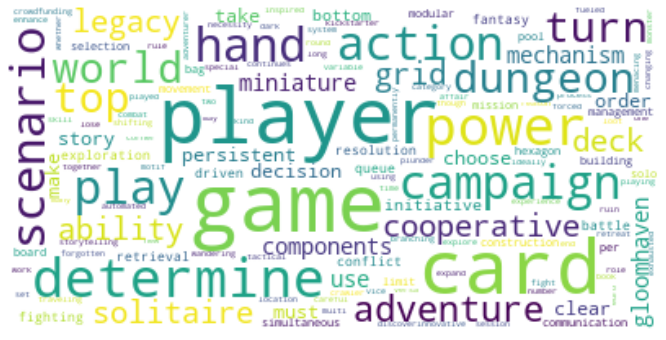

In [ ]:
bow = df[df.name == 'Gloomhaven']['bag_of_words'].item()
text = ''
for word in bow:
  text += (word + ' ')

create_wordcloud(text)

In [ ]:
count_pan2 = recommend('Pandemic', names, df, cos_sim, 5)
print(count_pan2)
print(count_pan)

['Pandemic', 'Rivals for Catan', 'HeroQuest', 'Ticket to Ride: The Card Game', 'Skull King']
['Pandemic', 'Rivals for Catan', 'Ticket to Ride: The Card Game', 'HeroQuest', 'Skull King']


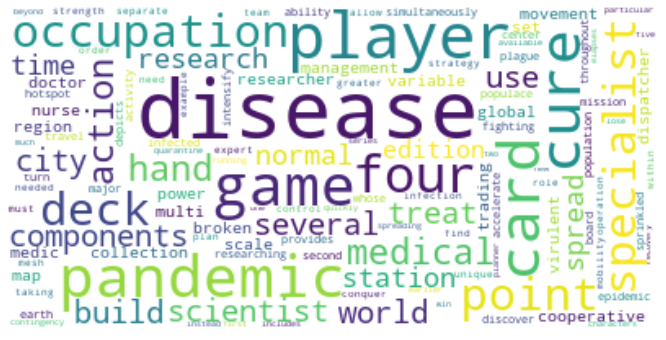

In [ ]:
bow = df[df.name == 'Pandemic']['bag_of_words'].item()
text = ''
for word in bow:
  text += (word + ' ')

create_wordcloud(text)

In [ ]:
count_carc2 = recommend('Carcassonne', names, df, cos_sim, 5)
print(count_carc2)
print(count_carc)

['Key Harvest', 'Infinite City', 'Carcassonne Big Box 5', 'Elfenland', 'The Castles of Burgundy']
['Key Harvest', 'Infinite City', 'Carcassonne Big Box 5', 'Elfenland', 'The Castles of Burgundy']


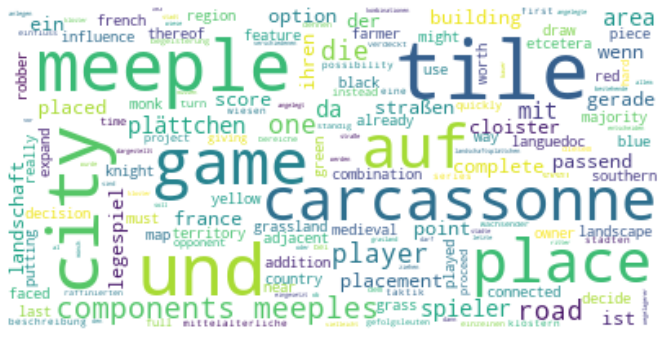

In [ ]:
bow = df[df.name == 'Carcassonne']['bag_of_words'].item()
text = ''
for word in bow:
  text += (word + ' ')

create_wordcloud(text)

In [ ]:
count_mon2 = recommend('Monopoly', names, df, cos_sim, 5)
print(count_mon2)
print(count_mon)

['Traders of Osaka', 'History of the World', 'Rivals for Catan', 'Risk Legacy', 'Ticket to Ride: The Card Game']
['Traders of Osaka', 'History of the World', 'Rivals for Catan', 'Risk Legacy', 'Ticket to Ride: The Card Game']


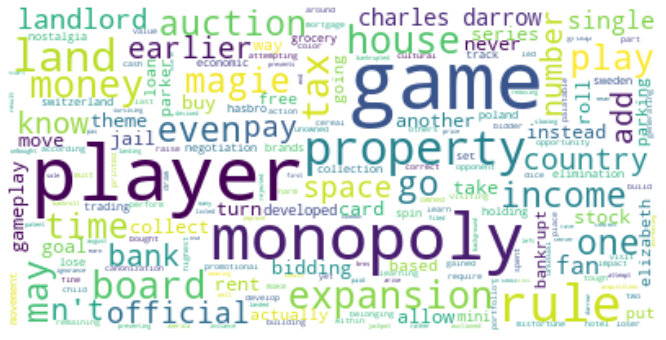

In [ ]:
bow = df[df.name == 'Monopoly']['bag_of_words'].item()
text = ''
for word in bow:
  text += (word + ' ')

create_wordcloud(text)

As expected, we had almost no change in our recommendations. A few games had orders switched, but overall no new recommendations. Looking at the wordclouds though, we have had some effect as the size of each game's name was reduced. Let's check the tf-idf vectorization with the new bag of words. Hopefully we will see some changes here.

In [ ]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=5, preprocessor=' '.join)
tfidf_matrix = tf.fit_transform(df['bag_of_words'])

cos_sim2 = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
tfidf_gloom2 = recommend('Gloomhaven', names, df, cos_sim2, 5)
print(tfidf_gloom2)
print(tfidf_gloom)

['Gloomhaven: Jaws of the Lion', 'First Martians: Adventures on the Red Planet', 'Dragonfire', 'Dungeons & Dragons: The Legend of Drizzt Board Game', 'SeaFall']
['Gloomhaven: Jaws of the Lion', 'Dragonfire', 'First Martians: Adventures on the Red Planet', 'Dungeons & Dragons: The Legend of Drizzt Board Game', 'SeaFall']


In [ ]:
tfidf_pan2 = recommend('Pandemic', names, df, cos_sim2, 5)
print(tfidf_pan2)
print(tfidf_pan)

['Pandemic Legacy: Season 1', 'Pandemic: Contagion', 'Pandemic: The Cure', 'Pandemic: Iberia', 'Pandemic: In the Lab']
['Pandemic: Contagion', 'Pandemic Legacy: Season 1', 'Pandemic: The Cure', 'Pandemic: Iberia', 'Pandemic: In the Lab']


In [ ]:
tfidf_carc2 = recommend('Carcassonne', names, df, cos_sim2, 5)
print(tfidf_carc2)
print(tfidf_carc)

['Carcassonne Big Box 5', 'Carcassonne: Expansion 1 – Inns & Cathedrals', 'Carcassonne: Expansion 5 – Abbey & Mayor', 'Glen More', 'Carcassonne Junior']
['Carcassonne Big Box 5', 'Carcassonne: Expansion 1 – Inns & Cathedrals', 'Carcassonne: Expansion 5 – Abbey & Mayor', 'Carcassonne: King & Scout', 'Carcassonne: Expansion 8 – Bridges, Castles and Bazaars']


In [ ]:
tfidf_mon2 = recommend('Monopoly', names, df, cos_sim2, 5)
print(tfidf_mon2)
print(tfidf_mon)

['Monopoly: Star Wars', 'Monopoly Deal Card Game', 'Last Will', 'Hotel Tycoon', 'Dice Town']
['Monopoly: Star Wars', 'Monopoly Deal Card Game', 'Last Will', 'Hotel Tycoon', 'Dice Town']


# Analysis

Unfortunately this did not solve our problem with seeing too many expansions. Most of the recommendations are exactly the same. The one notable change is that we had one fewer carcassonne expansion recommended. We could potentially reduce this effect further by trimming our bag of words down, but since we have two good models for recommendations already, I don't think that is necessary. I would recommend using the tf-idf model here as it seems very good for games that don't have many expansions. For instance, the recommendations for Gloomhaven and Monopoly are very good. I like that we see the one or two expansions/reprints available and other games that are very similar (ie Hotel Tycoon and Dice Town for monopoly). I also like that there was no crossover between games with the tf-idf model, showing that there were no prominent buzzwords drowning out the identifying phrases. This model does have a weakness when dealing with games with tons of expansions and reprints as seen with the recommendations for carcassonne and pandemic, but we are still identifying items that buyers might be interested in looking at.

In our next notebook we will begin to take user ratings into account when obtaining recommendations.